In [1]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import math
from heapq import heappop, heappush
import queue

class Map:

    def __init__(self):
        '''
        Default constructor
        '''

        self._width = 0
        self._height = 0
        self._cells = []
    

    def read_from_string(self, cell_str, width, height):
        '''
        Converting a string (with '#' representing obstacles and '.' representing free cells) to a grid
        '''
        self._width = width
        self._height = height
        self._cells = [[0 for _ in range(width)] for _ in range(height)]
        cell_lines = cell_str.split("\n")
        i = 0
        j = 0
        for l in cell_lines:
            if len(l) != 0:
                j = 0
                for c in l:
                    if c == '.':
                        self._cells[i][j] = 0
                    elif c == '#':
                        self._cells[i][j] = 1
                    else:
                        continue
                    j += 1
                if j != width:
                    raise Exception("Size Error. Map width = ", j, ", but must be", width )
                
                i += 1

        if i != height:
            raise Exception("Size Error. Map height = ", i, ", but must be", height )
    
     
    def set_grid_cells(self, width, height, grid_cells):
        '''
        Initialization of map by list of cells.
        '''
        self._width = width
        self._height = height
        self._cells = grid_cells


    def in_bounds(self, i, j):
        '''
        Check if the cell is on a grid.
        '''
        return (0 <= j < self._width) and (0 <= i < self._height)
    

    def traversable(self, i, j):
        '''
        Check if the cell is not an obstacle.
        '''
        return not self._cells[i][j]
    
    def get_neighbors(self, i, j):
        '''
        Get a list of neighbouring cells as (i,j) tuples.
        It's assumed that grid is 8-connected but cutting corners is prohibited
        '''
        neighbors = []
        delta = [[0, 1], [1, 0], [0, -1], [-1, 0]]
        for d in delta:
            if self.in_bounds(i + d[0], j + d[1]) and self.traversable(i + d[0], j + d[1]):
                neighbors.append((i + d[0], j + d[1]))
                
        delta = [[1, 1], [1, -1], [-1, 1], [-1, -1]]
        for d in delta:
            if self.in_bounds(i + d[0], j + d[1]) and self.traversable(i + d[0], j + d[1]) and \
            (self.traversable(i + d[0], j) or self.traversable(i, j + d[1])):
                neighbors.append((i + d[0], j + d[1]))

        return neighbors

    def get_size(self):
        return (self._height, self._width)

In [2]:
def compute_cost(i1, j1, i2, j2):
    '''
    Computes cost of a move between the adjacent cells
    '''
    if abs(i1 - i2) + abs(j1 - j2) == 1: #cardinal move
        return 1
    elif abs(i1 - i2) + abs(j1 - j2) == 2: #diagonal move
        return math.sqrt(2)
    else:
        raise Exception('Trying to compute the cost of a non-supported move! ONLY cardinal and diagonal moves are supported.')

In [3]:
class Node:
    '''
    Node class represents a search node

    - i, j: coordinates of corresponding grid element
    - g: g-value of the node
    - h: h-value of the node
    - F: f-value of the node
    - parent: pointer to the parent-node 

    You might want to add other fields/methods for Node
    '''

    def __init__(self, i, j, g = 0, h = 0, F = None, parent = None, k = 0):
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        if F is None:
            self.F = self.g + h
        else:
            self.F = F        
        self.parent = parent

    
    def __eq__(self, other):
        return (self.i == other.i) and (self.j == other.j)
    
    def __lt__(self, other):
        return self.F < other.F or ((self.F == other.F) and (self.h < other.h))

In [4]:
class Open:
    
    def __init__(self):
        self.elements = {}
        self.heap = []
    
    def __iter__(self):
        return iter(self.elements)
    
    def __len__(self):
        return len(self.elements)

    def isEmpty(self):
        if len(self.elements) != 0:
            return False
        
        return True

    def AddNode(self, node : Node, *args):
        if (node.i, node.j) not in self.elements or self.elements[(node.i, node.j)].g > node.g:
            self.elements.update({(node.i, node.j) : node})
            heappush(self.heap, node)
            
        return

    def GetBestNode(self, CLOSED, *args):
        best = heappop(self.heap)
        while CLOSED.WasExpanded(best):
            best = heappop(self.heap)
        del self.elements[(best.i, best.j)]
        return best

In [5]:
class Closed:
    
    def __init__(self):
        self.elements = {}


    def __iter__(self):
        return iter(self.elements)
    

    def __len__(self):
        return len(self.elements)


    def AddNode(self, item : Node):
        self.elements.update({(item.i, item.j) : item})


    def WasExpanded(self, item : Node):
        return (item.i, item.j) in self.elements

In [6]:
def diagonal_distance(i1, j1, i2, j2):
    return abs(abs(int(i1) - int(i2)) - abs(int(j1) - int(j2))) + \
            math.sqrt(2) * min(abs(int(i1) - int(i2)), abs(int(j1) - int(j2)))

In [7]:
def astar(grid_map, start_i, start_j, goal_i, goal_j, heuristic_func):

    OPEN = Open()
    CLOSED = Closed()
    
    start_node = Node(start_i, start_j, 0, heuristic_func(start_i, start_j, goal_i, goal_j))
    goal_node = Node(goal_i, goal_j, 0, 0)
    OPEN.AddNode(start_node)
    
    while not OPEN.isEmpty():
        next_node = OPEN.GetBestNode(CLOSED)
        CLOSED.AddNode(next_node)
    
        if next_node == goal_node:
            return (True, next_node, CLOSED.elements.values(), OPEN.elements.values())
            
        
        for nbr_node in grid_map.get_neighbors(next_node.i, next_node.j):
            if not CLOSED.WasExpanded(Node(i=nbr_node[0], j=nbr_node[1])):
                OPEN.AddNode( Node(i=nbr_node[0], 
                                   j=nbr_node[1], 
                                   g=next_node.g + compute_cost(next_node.i, next_node.j, nbr_node[0], nbr_node[1]), 
                                   h=heuristic_func(nbr_node[0], nbr_node[1], goal_i, goal_j),
                                   parent=next_node) )
                

    return False, None, CLOSED, OPEN

In [8]:
def make_path(goal):

    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

In [9]:
def read_map_from_movingai_file(path):
    
    mapFile = open(path)
    count = 0
    
    mapFile.readline()
    a = mapFile.readline().split(' ')
    height = int(a[1])
    a = mapFile.readline().split(' ')
    width = int(a[1])
    mapFile.readline()
    cells = [[0 for _ in range(width)] for _ in range(height)]
    i = 0
    j = 0

    for l in mapFile:
        j = 0
        for c in l:
            if c == '.' or c == 'G':
                cells[i][j] = 0
            elif c == '@' or c == 'O' or c == 'T':
                cells[i][j] = 1
            else:
                continue
            
            j += 1
            
        if j != width:
            raise Exception("Size Error. Map width = ", j, ", but must be", width, "(map line: ", i, ")")
                
        i += 1
        if(i == height):
            break  

    return (width, height, cells)

In [10]:
def read_tasks_from_movingai_file(path):

    tasksFile = open(path)
    tasks = []
    
    tasksFile.readline()
    for _ in range(200):
        line = tasksFile.readline().split('\t')
        mapFile = line[1]
        jStart = int(line[4])
        iStart = int(line[5])
        jGoal = int(line[6])
        iGoal = int(line[7])
        length = float(line[8])
        
        tasks.append((iStart, jStart, iGoal, jGoal, length))
        tasksFile.readline()
        
    for _ in range(50):
        line = tasksFile.readline().split('\t')
        mapFile = line[1]
        jStart = int(line[4])
        iStart = int(line[5])
        jGoal = int(line[6])
        iGoal = int(line[7])
        length = float(line[8])
        
        tasks.append((iStart, jStart, iGoal, jGoal, length))
    
    return tasks 

In [11]:
def Draw(gridMap : Map, start : Node = None, goal : Node = None, path : list = None, nodesExpanded = None, nodesOpened = None):
    '''
    Auxiliary function that visualizes the enviromnet, the path and OPEN and CLOSED.
    '''
    k = 5
    hIm = gridMap._height * k
    wIm = gridMap._width * k
    im = Image.new('RGB', (wIm, hIm), color = 'white')
    draw = ImageDraw.Draw(im)
    for i in range(gridMap._height):
        for j in range(gridMap._width):
            if(gridMap._cells[i][j] == 1):
                draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=( 70, 80, 80 ))

    if nodesOpened is not None:
        for node in nodesOpened:
            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(213, 219, 219), width=0)

    if nodesExpanded is not None:
        for node in nodesExpanded:
            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=( 131, 145, 146 ), width=0)

    if path is not None:
        for step in path:
            if (step is not None):
                if (gridMap.traversable(step.i, step.j)):
                    draw.rectangle((step.j * k, step.i * k, (step.j + 1) * k - 1, (step.i + 1) * k - 1), fill=(52, 152, 219), width=0)
                else:
                    draw.rectangle((step.j * k, step.i * k, (step.j + 1) * k - 1, (step.i + 1) * k - 1), fill=(230, 126, 34), width=0)

    if (start is not None) and (gridMap.traversable(start.i, start.j)):
        draw.rectangle((start.j * k, start.i * k, (start.j + 1) * k - 1, (start.i + 1) * k - 1), fill=(40, 180, 99), width=0)
    
    if (goal is not None) and (gridMap.traversable(goal.i, goal.j)):
        draw.rectangle((goal.j * k, goal.i * k, (goal.j + 1) * k - 1, (goal.i + 1) * k - 1), fill=(231, 76, 60), width=0)


    fig, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
#     plt.savefig('ht_chantry_A*.png', dpi=300, bbox_inches='tight')

In [12]:
def massive_test(search_function, *args):
    all_tasks_results = dict()
    averageNodes = 0
    averageSteps = 0
    
    all_tasks_results["corr"] = []
    all_tasks_results["len"] = []
    all_tasks_results["nc"] = []
    all_tasks_results["st"] = []
    taskNum = 4
    taskMap = Map()
    for taskCount in range(1, taskNum + 1):
        averageNodes = 0
        averageSteps = 0
        print('')
        print('               Карта ' + str(taskCount) + ', A*               ')
        mapFileName = "./maps/" + str(taskCount) + ".map"
        taskFileName = "./maps/" + str(taskCount) + ".map.scen"
        width, height, cells = read_map_from_movingai_file(mapFileName)
        tasks = read_tasks_from_movingai_file(taskFileName)
        
        i = 0
        taskMap.set_grid_cells(width,height,cells)
        for task in tasks:

            iStart, jStart, iGoal, jGoal, length = task
            try:
                result = search_function(taskMap, iStart, jStart, iGoal, jGoal, *args)
                nodesExpanded = result[2]
                nodesOpened = result[3]
                if result[0]:
                    path = make_path(result[1]) 
                    all_tasks_results["len"].append(path[1])
                    correct = int(path[1])  == int(length)
                    all_tasks_results["corr"].append(correct)
                    averageNodes += len(nodesOpened)
                    averageNodes += len(nodesExpanded)
                    averageSteps += len(nodesExpanded)
                    
                    if i == 218:
                        Draw(taskMap, Node(iStart, jStart), Node(iGoal, jGoal), make_path(result[1])[0], nodesExpanded, nodesOpened)
                    
                    print("№" + str(i) + ". Path found! Length: " + str(path[1]) + ". Visited: " + str(len(nodesOpened) + len(nodesExpanded)) + ". Expanded: " + str(len(nodesExpanded)))
                else:
                    #print("Path not found! " + str(iStart) + ", " + str(jStart) + "; " + str(iGoal) + ", " + str(jGoal))
                    all_tasks_results["corr"].append(False)
                    all_tasks_results["len"].append(0.0)

                all_tasks_results["nc"].append(len(nodesOpened) + len(nodesExpanded))
                all_tasks_results["st"].append(len(nodesExpanded))

            except Exception as e:
                print("Execution error")
                print(e)
            i += 1
                
        print("Average visited nodes: " + str(averageNodes / 250) + "; Average expanded nodes: " + str(averageSteps / 250))

    return all_tasks_results

In [13]:
import itertools, heapq, queue

# Define some constants representing the things that can be in a field.
OBSTACLE = -10
DESTINATION = -2
UNINITIALIZED = -1

expanded = [[False for j in range(150)] for i in range(200)]  
visited = [[False for j in range(150)] for i in range(200)]


# class FastPriorityQueue():

#     def __init__(self):
#         self.pq = []                         # list of entries arranged in a heap
#         self.counter = itertools.count()     # unique sequence count

#     def add_task(self, task, priority=0, h=0):
#         'Add a new task'
#         count = next(self.counter)
#         entry = [priority, h, count, task]
#         heapq.heappush(self.pq, entry)

#     def pop_task(self):
#         'Remove and return the lowest priority task. Raise KeyError if empty.'
#         while self.pq:
#             priority, h, count, task = heapq.heappop(self.pq)
#             return task
#         raise KeyError('pop from an empty priority queue')

#     def empty(self):
#         return len(self.pq) == 0

    
def sign(curr, ances):
    if curr - ances > 0:
        return 1
    if curr - ances == 0:
        return 0
    if curr - ances < 0:
        return -1

In [14]:
def jps(field, start_x, start_y, end_x, end_y):
    """    
    Parameters
    field            - 2d array representing the g-value.
    start_x, start_y - the x, y coordinates of the start
    end_x, end_y     - the x, y coordinates of the destination

    Return:
    a list of tuples corresponding to the jump points.
    OR
    [] if no path is found. 
    """
    global expanded, visited
    expanded = [[False for j in range(len(field[0]))] for i in range(len(field))]  
    visited = [[False for j in range(len(field[0]))] for i in range(len(field))]  
        
    
    if field[start_x][start_y] == OBSTACLE:
        raise ValueError("No path exists: the start node is not walkable")
    if field[end_x][end_y] == OBSTACLE:
        raise ValueError("No path exists: the end node is not walkable")
    
    xMax = len(field)
    yMax = len(field[0])
    
    pq = []
    heapq.heapify(pq)

    class FoundPath(Exception):
        """ Raise this when you found a path. it's not really an error,
        but we need to stop the program and pass it up to the real function"""
        pass

    def queue_jumppoint(node):
        """
        Add a jump point to the priority queue to be searched later. 
        Also check whether the search is finished.

        Parameters
        pq - a priority queue for the jump point search
        node - 2-tuple with the coordinates of a point to add.
        """
        if node is not None:
            heapq.heappush (pq, (field [node[0]] [node[1]] + 2**(0.5)*min(abs(node[0] - end_x), abs(node[1] - end_y)) +\
                                 max(abs(node[0] - end_x), abs(node[1] - end_y)) - min(abs(node[0] - end_x), abs(node[1] - end_y)), 
                                 2**(0.5) * min(abs(node[0] - end_x), abs(node[1] - end_y)) +\
                                 max(abs(node[0] - end_x), abs(node[1] - end_y)) - min(abs(node[0] - end_x), abs(node[1] - end_y)),
                                 node))
                         
            
    def _jps_explore_diagonal (startX, startY, directionX, directionY):
        """
        Parameters
        startX, startY - the coordinates to start exploring from. 
        directionX, directionY - an element from: {(1, 1), (-1, 1), (-1, -1), (1, -1)} corresponding to the x and y directions respectively. 

        Return
        A 2-tuple containing the coordinates of the jump point if it found one
        None if no jumppoint was found. 
        """
        cur_x, cur_y = startX, startY
        curCost = field [startX] [startY]

        while(True):
            cur_x += directionX
            cur_y += directionY
            curCost += 2 ** (0.5)
            
            if cur_x < 0 or cur_x >= xMax or cur_y < 0 or cur_y >= yMax:
                return None
            if field [cur_x] [cur_y] == UNINITIALIZED:
                field [cur_x] [cur_y] = curCost
                sources [cur_x] [cur_y] = startX, startY
                visited [cur_x][cur_y] = True    
            elif cur_x == end_x and cur_y == end_y:  # destination found
                field [cur_x][cur_y] = curCost
                sources [cur_x] [cur_y] = startX, startY
                visited[cur_x][cur_y] = True
                raise FoundPath()
            else: # collided with an obstacle.
                return None

            # If a jump point is found, 
            if cur_y + directionY >= 0 and cur_y + directionY < yMax and field [cur_x - directionX] [cur_y] == OBSTACLE and field [cur_x - directionX] [cur_y + directionY] != OBSTACLE:
                return (cur_x, cur_y)
            else: # otherwise, extend a horizontal direction.
                queue_jumppoint(_jps_explore_cardinal (cur_x, cur_y, directionX, 0))

            if cur_x + directionX >= 0 and cur_x + directionX < xMax and field [cur_x] [cur_y - directionY] == OBSTACLE and field [cur_x + directionX] [cur_y - directionY] != OBSTACLE:
                return (cur_x, cur_y)
            else: # extend a vertical direction 
                queue_jumppoint(_jps_explore_cardinal (cur_x, cur_y, 0, directionY))

    def _jps_explore_cardinal (startX, startY, directionX, directionY):
        """
        Parameters
        startX, startY - the coordinates to start exploring from. 
        directionX, directionY - an element from: {(1, 0), (-1, 0), (0, 1), (0, -1)}. 

        Result: 
        A 2-tuple containing the coordinates of the jump point if it found one
        """
        cur_x, cur_y = startX, startY 
        curCost = field [startX] [startY]

        while (True):
            cur_x += directionX
            cur_y += directionY
            curCost += 1
            
            if cur_x < 0 or cur_x >= xMax or cur_y < 0 or cur_y >= yMax:
                return None
            if field [cur_x][cur_y] == UNINITIALIZED:
                field [cur_x][cur_y] = curCost
                sources [cur_x][cur_y] = startX, startY
                visited[cur_x][cur_y] = True  
            elif cur_x == end_x and cur_y == end_y:  # destination found
                field [cur_x][cur_y] = curCost
                sources [cur_x][cur_y] = startX, startY
                visited[cur_x][cur_y] = True
                raise FoundPath()
            else: # collided with an obstacle or previously explored part. 
                return None

            # check neighbouring cells, if cur_x, cur_y is a jump point. 
            if directionX == 0: 
                if cur_x+1 < xMax and cur_y+directionY >= 0 and cur_y+directionY < yMax and field [cur_x+1][cur_y] == OBSTACLE and field [cur_x+1] [cur_y+directionY] != OBSTACLE:
                    return cur_x, cur_y
                if cur_x-1 >= 0 and cur_y+directionY >= 0 and cur_y+directionY < yMax and field [cur_x-1][cur_y] == OBSTACLE and field [cur_x-1] [cur_y+directionY] != OBSTACLE:
                    return cur_x, cur_y
            elif directionY == 0:
                if cur_y + 1 < yMax and cur_x + directionX >= 0 and cur_x + directionX < xMax and field [cur_x] [cur_y + 1] == OBSTACLE and field [cur_x + directionX] [cur_y + 1] != OBSTACLE:
                    return cur_x, cur_y
                if cur_y - 1 >= 0 and cur_x + directionX >= 0 and cur_x + directionX < xMax and field [cur_x] [cur_y - 1] == OBSTACLE and field [cur_x + directionX] [cur_y - 1] != OBSTACLE:
                    return cur_x, cur_y

    # MAIN JPS FUNCTION
    field = [[j for j in i] for i in field]  # this takes less time than deep copying. 

    # Initialize some arrays and certain elements. 
    sources = [[(None, None) for i in field[0]] for j in field]  # the jump-point predecessor to each point.
    field [start_x] [start_y] = 0
    if(start_x == end_x and start_y == end_y):
        return _get_path(sources, start_x, start_y, end_x, end_y), 1, 1, [(end_x, end_y)], [(end_x, end_y)]
    
    field [end_x] [end_y] = DESTINATION

#     pq = FastPriorityQueue()
    queue_jumppoint((start_x, start_y))

    # Main loop: iterate through the queue
    while (len(pq) != 0):
        (pX, pY) = heapq.heappop(pq)[2]
        expanded[pX][pY] = True 
        
        try:
            if (pX, pY) == (start_x, start_y):
                if pY+1 < yMax:
                    queue_jumppoint(_jps_explore_cardinal (pX, pY, 0, 1))
                if pY-1 >= 0:
                    queue_jumppoint(_jps_explore_cardinal (pX, pY, 0, -1))
                if pX+1 < xMax:
                    queue_jumppoint(_jps_explore_cardinal (pX, pY, 1, 0))
                if pX-1 >= 0:
                    queue_jumppoint(_jps_explore_cardinal (pX, pY, -1, 0))
                if pX+1 < xMax and pY+1 < yMax and (field[pX+1][pY] != OBSTACLE or field[pX][pY+1] != OBSTACLE):
                    queue_jumppoint(_jps_explore_diagonal (pX, pY, 1, 1))
                if pX+1 < xMax and pY-1 >= 0 and (field[pX+1][pY] != OBSTACLE or field[pX][pY-1] != OBSTACLE):    
                    queue_jumppoint(_jps_explore_diagonal (pX, pY, 1, -1))
                if pX-1 >= 0 and pY+1 < yMax and (field[pX-1][pY] != OBSTACLE or field[pX][pY+1] != OBSTACLE):
                    queue_jumppoint(_jps_explore_diagonal (pX, pY, -1, 1))
                if pX-1 >= 0 and pY-1 >= 0 and (field[pX-1][pY] != OBSTACLE or field[pX][pY-1] != OBSTACLE):
                    queue_jumppoint(_jps_explore_diagonal (pX, pY, -1, -1))
                
            elif (sources[pX][pY][0] != pX) and (sources[pX][pY][1] != pY):
                dX = sign(pX, sources[pX][pY][0])
                dY = sign(pY, sources[pX][pY][1])
                if pX+dX < xMax and pX+dX >= 0 and pY+dY < yMax and pY+dY >= 0 and (field[pX+dX][pY] != OBSTACLE or field[pX][pY+dY] != OBSTACLE):
                    queue_jumppoint(_jps_explore_diagonal (pX, pY, dX, dY))
                if pX+dX < xMax and pX+dX >= 0:
                    queue_jumppoint(_jps_explore_cardinal (pX, pY, dX, 0))
                if pY+dY < yMax and pY+dY >= 0:
                    queue_jumppoint(_jps_explore_cardinal (pX, pY, 0, dY))
                if pX+dX < xMax and pX+dX >= 0 and pY-dY < yMax and pY-dY >= 0 and (field[pX][pY-dY] == OBSTACLE) and (field[pX+dX][pY] != OBSTACLE):
                    queue_jumppoint(_jps_explore_diagonal (pX, pY, dX, -dY))
                if pX-dX < xMax and pX-dX >= 0 and pY+dY < yMax and pY+dY >= 0 and (field[pX-dX][pY] == OBSTACLE) and (field[pX][pY+dY] != OBSTACLE):
                    queue_jumppoint(_jps_explore_diagonal (pX, pY, -dX, dY))

            elif (sources[pX][pY][0] != pX):
                dX = sign(pX, sources[pX][pY][0])
                if pX+dX < xMax and pX+dX >= 0:
                    queue_jumppoint(_jps_explore_cardinal (pX, pY, dX, 0))
                if  pX+dX < xMax and pX+dX >= 0 and pY-1 >= 0 and(field[pX][pY-1] == OBSTACLE) and (field[pX+dX][pY] != OBSTACLE):
                    queue_jumppoint(_jps_explore_diagonal (pX, pY, dX, -1))
                if  pX+dX < xMax and pX+dX >= 0 and pY+1 < yMax and(field[pX][pY+1] == OBSTACLE) and (field[pX+dX][pY] != OBSTACLE):
                    queue_jumppoint(_jps_explore_diagonal (pX, pY, dX, 1))

            elif (sources[pX][pY][1] != pY):
                dY = sign(pY, sources[pX][pY][1])
                if pY+dY < yMax and pY+dY >= 0:
                    queue_jumppoint(_jps_explore_cardinal (pX, pY, 0, dY))
                if pX-1 >= 0 and pY+dY < yMax and pY+dY >= 0 and (field[pX-1][pY] == OBSTACLE) and (field[pX][pY+dY] != OBSTACLE):
                    queue_jumppoint(_jps_explore_diagonal (pX, pY, -1, dY))
                if pX+1 < xMax and pY+dY < yMax and pY+dY >= 0 and(field[pX+1][pY] == OBSTACLE) and (field[pX][pY+dY] != OBSTACLE):
                    queue_jumppoint(_jps_explore_diagonal (pX, pY, 1, dY))

        except FoundPath:
            visited_count = 0
            vis_nodes = []
            for i in range(len(visited)):
                for j in range(len(visited[i])):
                    if visited[i][j] == True:
                        visited_count += 1
                        vis_nodes.append((i, j))
            expanded_count = 0
            exp_nodes = []
            for i in range(len(expanded)):
                for j in range(len(expanded[i])):
                    if expanded[i][j] == True:
                        expanded_count += 1
                        exp_nodes.append((i, j))
            return _get_path(sources, start_x, start_y, end_x, end_y), visited_count, expanded_count, vis_nodes, exp_nodes

    raise ValueError("No path is found")

In [15]:
# pq = []
# heapq.heapify(pq)
# heapq.heappush(pq, (6, 5, (1, 1)))
# heapq.heappush(pq, (5, 7, (10, 10)))
# heapq.heappush(pq, (5, 5, (10, 10)))
# print(heapq.heappop(pq))


In [16]:
def _get_path(sources, start_x, start_y, end_x, end_y):
    
    result = []
    cur_x, cur_y = end_x, end_y
    
    while cur_x != start_x or cur_y != start_y:
        result.append((cur_x, cur_y))
        cur_x, cur_y = sources[cur_x][cur_y]
    result.reverse()
    return [(start_x, start_y)] + result

In [17]:
def get_full_path(path):
    
    if path == []:
        return []
    
    cur_x, cur_y = path[0]
    result = [(cur_x, cur_y)]
    for i in range(len(path) - 1):
        while cur_x != path[i + 1][0] or cur_y != path[i + 1][1]:
            cur_x += sign(path[i + 1][0], path[i][0])
            cur_y += sign(path[i + 1][1], path[i][1])
            result.append((cur_x, cur_y))
    return result

In [18]:
def my_read_map_from_movingai_file(path):
    
    mapFile = open(path)
    count = 0
    
    mapFile.readline()
    a = mapFile.readline().split(' ')
    height = int(a[1])
    a = mapFile.readline().split(' ')
    width = int(a[1])
    mapFile.readline()
    cells = [[0 for _ in range(width)] for _ in range(height)]
    i = 0
    j = 0

    for l in mapFile:
        j = 0
        for c in l:
            if c == '.' or c == 'G':
                cells[i][j] = -1
            elif c == '@' or c == 'O' or c == 'T':
                cells[i][j] = -10
            else:
                continue
            
            j += 1
            
        if j != width:
            raise Exception("Size Error. Map width = ", j, ", but must be", width, "(map line: ", i, ")")
                
        i += 1
        if(i == height):
            break  

    return (width, height, cells)

In [19]:
def my_read_tasks_from_movingai_file(path):

    tasksFile = open(path)
    tasks = []
    
    tasksFile.readline()
    for _ in range(200):
        line = tasksFile.readline().split('\t')
        mapFile = line[1]
        jStart = int(line[4])
        iStart = int(line[5])
        jGoal = int(line[6])
        iGoal = int(line[7])
        length = float(line[8])
        
        tasks.append((iStart, jStart, iGoal, jGoal, length))
        tasksFile.readline()
        
    for _ in range(50):
        line = tasksFile.readline().split('\t')
        mapFile = line[1]
        jStart = int(line[4])
        iStart = int(line[5])
        jGoal = int(line[6])
        iGoal = int(line[7])
        length = float(line[8])
        
        tasks.append((iStart, jStart, iGoal, jGoal, length))
    
    return tasks

In [20]:
def path_lenth(path):
    anw = 0
    for i in range(len(path) - 1):
        anw += ((path[i][0] - path[i + 1][0]) ** 2 + (path[i][1] - path[i + 1][1]) ** 2) ** (0.5)

    return anw

In [21]:
def Draw_JPS(field, start = None, goal = None, jump : list = None, path : list = None, nodesExpanded = None, nodesVisited = None):
    '''
    Auxiliary function that visualizes the enviromnet, the path and OPEN and CLOSED.
    '''
    k = 5
    hIm = len(field) * k
    wIm = len(field[0]) * k
    im = Image.new('RGB', (wIm, hIm), color = 'white')
    draw = ImageDraw.Draw(im)
    for i in range(len(field)): # height
        for j in range(len(field[0])): # weight
            if(field[i][j] == OBSTACLE):
                draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=( 70, 80, 80 ))

    if nodesVisited is not None:
        for (i, j) in nodesVisited:
            draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=(213, 219, 219), width=0)

    if nodesExpanded is not None:
        for (i, j) in nodesExpanded:
            draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=(131, 145, 146 ), width=0)

    if path is not None:
        for step in path:
            if (step is not None):
                if (field [step[0]] [step[1]] != OBSTACLE):
                    draw.rectangle((step[1] * k, step[0] * k, (step[1] + 1) * k - 1, (step[0] + 1) * k - 1), fill=(52, 152, 219), width=0)
                else:
                    draw.rectangle((step[1] * k, step[0] * k, (step[1] + 1) * k - 1, (step[0] + 1) * k - 1), fill=(230, 126, 34), width=0)
                    
    if jump is not None:
        for step in jump:
            if (step is not None):
                if (field [step[0]] [step[1]] != OBSTACLE):
                    draw.rectangle((step[1] * k, step[0] * k, (step[1] + 1) * k - 1, (step[0] + 1) * k - 1), fill=(255, 0, 0), width=0)
                else:
                    draw.rectangle((step[1] * k, step[0] * k, (step[1] + 1) * k - 1, (step[0] + 1) * k - 1), fill=(230, 126, 34), width=0)

    if (start is not None) and (field [start[0]] [start[1]] != OBSTACLE):
        draw.rectangle((start[1] * k, start[0] * k, (start[1] + 1) * k - 1, (start[0] + 1) * k - 1), fill=(40, 180, 99), width=0)
    
    if (goal is not None) and (field [goal[0]] [goal[1]] != OBSTACLE):
        draw.rectangle((goal[1] * k, goal[0] * k, (goal[1] + 1) * k - 1, (goal[0] + 1) * k - 1), fill=(231, 76, 60), width=0)


    fig, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
#     plt.savefig('ht_chantry_JPS.png', dpi=300, bbox_inches='tight')

In [22]:
def jps_test():
    all_tasks_results = dict()    
    all_tasks_results["len"] = []
    all_tasks_results["vis"] = []
    all_tasks_results["ex"] = []
    
    taskNum = 4
    for taskCount in range(1, taskNum + 1):
        averageVisited = 0
        averageExpanded = 0
        print('')
        print('               Карта ' + str(taskCount) + ', JPS               ')
    
        path_to_map = "./maps/" + str(taskCount) + ".map"
        path_to_task = "./maps/" + str(taskCount) + ".map.scen"

        Map = my_read_map_from_movingai_file(path_to_map)
        Task = my_read_tasks_from_movingai_file(path_to_task)

        i = 0
        for t in Task:
            path_coord, visited, expanded, map_visit, map_exp = jps(Map[2], t[0], t[1], t[2], t[3])
            d = path_lenth(path_coord)
            all_tasks_results["len"].append(d)
            all_tasks_results["vis"].append(visited)
            all_tasks_results["ex"].append(expanded)

            averageVisited += visited
            averageExpanded += expanded
            
            if i == 218:
                Draw_JPS(Map[2], (t[0], t[1]), (t[2], t[3]), path_coord, get_full_path(path_coord), map_exp, map_visit)
            print("№" + str(i) + ". Path found! Length: " + str(d) + ". Visited: " + str(visited) + ". Expanded: " + str(expanded))
            i += 1

        print("Average visited nodes: " + str(averageVisited / 250) + "; Average expanded nodes: " + str(averageExpanded / 250))

    return all_tasks_results


               Карта 1, A*               
№0. Path found! Length: 3.414213562373095. Visited: 17. Expanded: 4
№1. Path found! Length: 2.8284271247461903. Visited: 14. Expanded: 3
№2. Path found! Length: 2.414213562373095. Visited: 14. Expanded: 3
№3. Path found! Length: 2. Visited: 12. Expanded: 3
№4. Path found! Length: 2.414213562373095. Visited: 13. Expanded: 3
№5. Path found! Length: 6.82842712474619. Visited: 28. Expanded: 7
№6. Path found! Length: 6.656854249492381. Visited: 29. Expanded: 6
№7. Path found! Length: 4.414213562373095. Visited: 20. Expanded: 5
№8. Path found! Length: 7.82842712474619. Visited: 27. Expanded: 8
№9. Path found! Length: 4.82842712474619. Visited: 22. Expanded: 5
№10. Path found! Length: 11.485281374238571. Visited: 45. Expanded: 10
№11. Path found! Length: 10.82842712474619. Visited: 40. Expanded: 11
№12. Path found! Length: 9.899494936611667. Visited: 38. Expanded: 8
№13. Path found! Length: 10.65685424949238. Visited: 38. Expanded: 10
№14. Path found

№121. Path found! Length: 98.11269837220806. Visited: 986. Expanded: 771
№122. Path found! Length: 96.87005768508877. Visited: 1668. Expanded: 1510
№123. Path found! Length: 99.24264068711928. Visited: 358. Expanded: 180
№124. Path found! Length: 93.8822509939085. Visited: 1679. Expanded: 1564
№125. Path found! Length: 102.59797974644661. Visited: 1631. Expanded: 1524
№126. Path found! Length: 99.32590180780444. Visited: 1537. Expanded: 1393
№127. Path found! Length: 101.18376618407353. Visited: 1798. Expanded: 1626
№128. Path found! Length: 98.87005768508878. Visited: 1212. Expanded: 1079
№129. Path found! Length: 97.98275605729684. Visited: 1712. Expanded: 1594
№130. Path found! Length: 103.52691193458115. Visited: 1833. Expanded: 1672
№131. Path found! Length: 104.45584412271572. Visited: 474. Expanded: 263
№132. Path found! Length: 105.5685424949237. Visited: 1024. Expanded: 862
№133. Path found! Length: 104.69848480983494. Visited: 1396. Expanded: 1188
№134. Path found! Length: 10

№232. Path found! Length: 171.66904755831217. Visited: 3642. Expanded: 3445
№233. Path found! Length: 170.29646455628168. Visited: 2778. Expanded: 2587
№234. Path found! Length: 174.71067811865473. Visited: 2446. Expanded: 2208
№235. Path found! Length: 173.98275605729694. Visited: 2354. Expanded: 2137
№236. Path found! Length: 171.32590180780463. Visited: 2530. Expanded: 2371
№237. Path found! Length: 171.39696961967002. Visited: 2611. Expanded: 2454
№238. Path found! Length: 171.91168824543146. Visited: 2834. Expanded: 2498
№239. Path found! Length: 171.49747468305827. Visited: 3935. Expanded: 3730
№240. Path found! Length: 174.15432893255087. Visited: 6264. Expanded: 6019
№241. Path found! Length: 175.1543289325508. Visited: 2973. Expanded: 2651
№242. Path found! Length: 174.49747468305839. Visited: 5136. Expanded: 4876
№243. Path found! Length: 175.5979797464467. Visited: 4448. Expanded: 4138
№244. Path found! Length: 175.88225099390849. Visited: 3329. Expanded: 3051
№245. Path fou

№97. Path found! Length: 76.55634918610403. Visited: 1117. Expanded: 973
№98. Path found! Length: 79.74011537017756. Visited: 265. Expanded: 69
№99. Path found! Length: 79.1837661840735. Visited: 1171. Expanded: 995
№100. Path found! Length: 82.29646455628159. Visited: 583. Expanded: 380
№101. Path found! Length: 82.25483399593902. Visited: 676. Expanded: 501
№102. Path found! Length: 81.39696961966993. Visited: 275. Expanded: 87
№103. Path found! Length: 80.36753236814705. Visited: 307. Expanded: 83
№104. Path found! Length: 83.87005768508877. Visited: 272. Expanded: 77
№105. Path found! Length: 84.18376618407353. Visited: 633. Expanded: 473
№106. Path found! Length: 85.15432893255063. Visited: 289. Expanded: 73
№107. Path found! Length: 85.61017305526633. Visited: 430. Expanded: 192
№108. Path found! Length: 84.69848480983498. Visited: 652. Expanded: 477
№109. Path found! Length: 87.01219330881973. Visited: 376. Expanded: 192
№110. Path found! Length: 89.79898987322333. Visited: 538.

№209. Path found! Length: 163.18376618407356. Visited: 7654. Expanded: 7310
№210. Path found! Length: 166.48023074035518. Visited: 1610. Expanded: 1192
№211. Path found! Length: 165.5391052434011. Visited: 3795. Expanded: 3410
№212. Path found! Length: 166.8233764908629. Visited: 3507. Expanded: 3132
№213. Path found! Length: 165.48023074035518. Visited: 1503. Expanded: 1075
№214. Path found! Length: 165.61017305526633. Visited: 798. Expanded: 433
№215. Path found! Length: 163.65180361560908. Visited: 2342. Expanded: 1993
№216. Path found! Length: 164.29646455628173. Visited: 3506. Expanded: 3138
№217. Path found! Length: 166.88225099390854. Visited: 1464. Expanded: 1069
№218. Path found! Length: 166.98275605729708. Visited: 4091. Expanded: 3761
№219. Path found! Length: 166.8528137423856. Visited: 2561. Expanded: 2143
№220. Path found! Length: 170.2081528017132. Visited: 7104. Expanded: 6711
№221. Path found! Length: 168.29646455628168. Visited: 2240. Expanded: 1915
№222. Path found! 

№83. Path found! Length: 64.01219330881972. Visited: 724. Expanded: 575
№84. Path found! Length: 67.31370849898477. Visited: 218. Expanded: 83
№85. Path found! Length: 68.45584412271569. Visited: 338. Expanded: 192
№86. Path found! Length: 67.69848480983497. Visited: 509. Expanded: 410
№87. Path found! Length: 69.18376618407356. Visited: 1681. Expanded: 1496
№88. Path found! Length: 69.48528137423855. Visited: 367. Expanded: 212
№89. Path found! Length: 69.65685424949238. Visited: 167. Expanded: 69
№90. Path found! Length: 75.11269837220803. Visited: 248. Expanded: 67
№91. Path found! Length: 72.94112549695426. Visited: 1461. Expanded: 1307
№92. Path found! Length: 75.35533905932733. Visited: 234. Expanded: 66
№93. Path found! Length: 72.97056274847714. Visited: 231. Expanded: 69
№94. Path found! Length: 74.4680374315354. Visited: 256. Expanded: 58
№95. Path found! Length: 78.56854249492373. Visited: 261. Expanded: 63
№96. Path found! Length: 78.65685424949237. Visited: 286. Expanded: 

№195. Path found! Length: 158.50966799187808. Visited: 5280. Expanded: 4915
№196. Path found! Length: 159.4974746830583. Visited: 1947. Expanded: 1679
№197. Path found! Length: 157.26702730475876. Visited: 4657. Expanded: 4401
№198. Path found! Length: 157.9655121145938. Visited: 3463. Expanded: 3062
№199. Path found! Length: 156.7817459305203. Visited: 4861. Expanded: 4525
№200. Path found! Length: 159.96551211459376. Visited: 5485. Expanded: 5246
№201. Path found! Length: 161.65180361560886. Visited: 1658. Expanded: 1114
№202. Path found! Length: 158.86500705120557. Visited: 2645. Expanded: 2232
№203. Path found! Length: 157.09545442950503. Visited: 2159. Expanded: 1897
№204. Path found! Length: 160.83556979968264. Visited: 1096. Expanded: 671
№205. Path found! Length: 162.36753236814704. Visited: 3885. Expanded: 3563
№206. Path found! Length: 159.76450198781717. Visited: 894. Expanded: 502
№207. Path found! Length: 159.61017305526633. Visited: 3856. Expanded: 3545
№208. Path found! 

№82. Path found! Length: 63.55634918610403. Visited: 557. Expanded: 502
№83. Path found! Length: 64.24264068711928. Visited: 391. Expanded: 259
№84. Path found! Length: 65.45584412271567. Visited: 723. Expanded: 648
№85. Path found! Length: 70.79898987322332. Visited: 347. Expanded: 227
№86. Path found! Length: 68.04163056034261. Visited: 541. Expanded: 430
№87. Path found! Length: 67.45584412271567. Visited: 886. Expanded: 802
№88. Path found! Length: 69.41421356237309. Visited: 211. Expanded: 70
№89. Path found! Length: 67.28427124746187. Visited: 719. Expanded: 607
№90. Path found! Length: 73.69848480983497. Visited: 792. Expanded: 711
№91. Path found! Length: 75.55634918610403. Visited: 240. Expanded: 112
№92. Path found! Length: 73.62741699796948. Visited: 474. Expanded: 346
№93. Path found! Length: 74.79898987322332. Visited: 775. Expanded: 649
№94. Path found! Length: 72.8700576850888. Visited: 445. Expanded: 316
№95. Path found! Length: 76.55634918610403. Visited: 634. Expanded

№196. Path found! Length: 158.698484809835. Visited: 2128. Expanded: 2018
№197. Path found! Length: 155.2548339959391. Visited: 2967. Expanded: 2789
№198. Path found! Length: 155.66904755831212. Visited: 2473. Expanded: 2355
№199. Path found! Length: 158.9705627484772. Visited: 1068. Expanded: 802
№200. Path found! Length: 162.4264068711928. Visited: 3479. Expanded: 3327
№201. Path found! Length: 159.63961030678925. Visited: 1953. Expanded: 1818
№202. Path found! Length: 161.39696961966996. Visited: 1907. Expanded: 1761
№203. Path found! Length: 160.4680374315355. Visited: 1736. Expanded: 1603
№204. Path found! Length: 160.1126983722082. Visited: 1956. Expanded: 1833
№205. Path found! Length: 159.8994949366117. Visited: 2131. Expanded: 2064
№206. Path found! Length: 158.88225099390854. Visited: 2707. Expanded: 2568
№207. Path found! Length: 162.4264068711929. Visited: 1963. Expanded: 1808
№208. Path found! Length: 161.1837661840736. Visited: 3970. Expanded: 3827
№209. Path found! Lengt

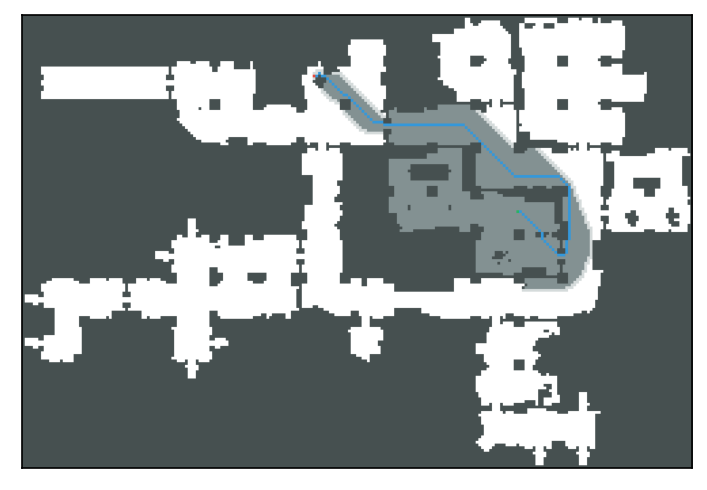

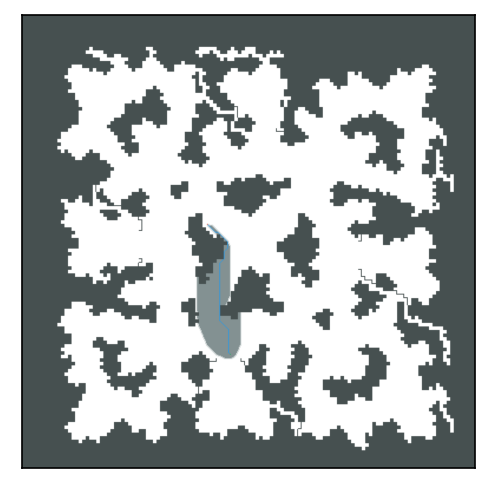

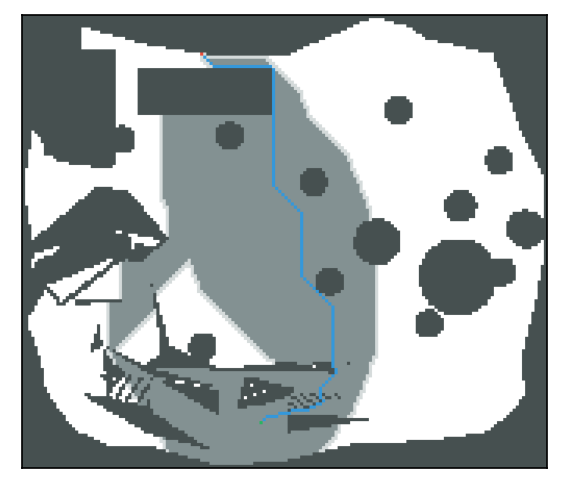

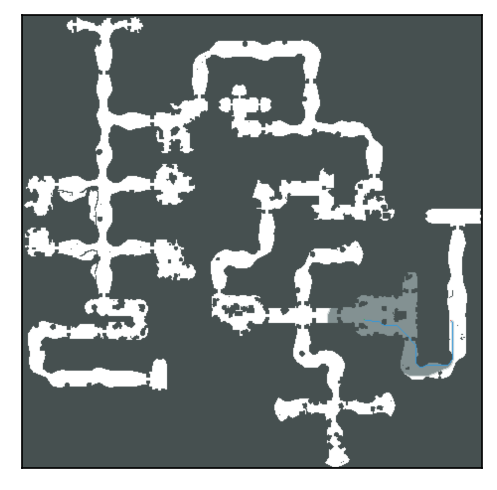

In [23]:
%time astar_data = massive_test(astar, diagonal_distance)


               Карта 1, JPS               
№0. Path found! Length: 3.414213562373095. Visited: 347. Expanded: 1
№1. Path found! Length: 2.8284271247461903. Visited: 177. Expanded: 1
№2. Path found! Length: 2.414213562373095. Visited: 77. Expanded: 1
№3. Path found! Length: 2.0. Visited: 15. Expanded: 1
№4. Path found! Length: 2.414213562373095. Visited: 89. Expanded: 1
№5. Path found! Length: 6.82842712474619. Visited: 128. Expanded: 1
№6. Path found! Length: 6.656854249492381. Visited: 398. Expanded: 1
№7. Path found! Length: 4.414213562373095. Visited: 905. Expanded: 1
№8. Path found! Length: 7.82842712474619. Visited: 64. Expanded: 1
№9. Path found! Length: 4.82842712474619. Visited: 246. Expanded: 1
№10. Path found! Length: 11.48528137423857. Visited: 382. Expanded: 1
№11. Path found! Length: 10.82842712474619. Visited: 274. Expanded: 1
№12. Path found! Length: 9.899494936611665. Visited: 895. Expanded: 1
№13. Path found! Length: 10.65685424949238. Visited: 541. Expanded: 1
№14. P

№117. Path found! Length: 91.76955262170046. Visited: 3381. Expanded: 37
№118. Path found! Length: 93.59797974644667. Visited: 1888. Expanded: 9
№119. Path found! Length: 92.59797974644665. Visited: 3955. Expanded: 32
№120. Path found! Length: 96.18376618407356. Visited: 2359. Expanded: 9
№121. Path found! Length: 98.11269837220809. Visited: 1889. Expanded: 11
№122. Path found! Length: 96.87005768508881. Visited: 2833. Expanded: 24
№123. Path found! Length: 99.24264068711928. Visited: 1309. Expanded: 5
№124. Path found! Length: 93.88225099390856. Visited: 2992. Expanded: 47
№125. Path found! Length: 103.76955262170048. Visited: 2313. Expanded: 49
№126. Path found! Length: 99.32590180780451. Visited: 3089. Expanded: 38
№127. Path found! Length: 101.18376618407356. Visited: 4110. Expanded: 25
№128. Path found! Length: 98.87005768508881. Visited: 2460. Expanded: 19
№129. Path found! Length: 101.49747468305831. Visited: 3060. Expanded: 46
№130. Path found! Length: 104.35533905932736. Visit

№238. Path found! Length: 171.9116882454314. Visited: 5362. Expanded: 69
№239. Path found! Length: 171.4974746830583. Visited: 4809. Expanded: 61
№240. Path found! Length: 174.15432893255067. Visited: 8138. Expanded: 122
№241. Path found! Length: 175.15432893255073. Visited: 4217. Expanded: 29
№242. Path found! Length: 174.49747468305833. Visited: 7349. Expanded: 98
№243. Path found! Length: 175.59797974644667. Visited: 7214. Expanded: 90
№244. Path found! Length: 175.88225099390857. Visited: 4593. Expanded: 56
№245. Path found! Length: 176.0416305603426. Visited: 4830. Expanded: 60
№246. Path found! Length: 177.66904755831212. Visited: 9159. Expanded: 131
№247. Path found! Length: 178.1543289325507. Visited: 4949. Expanded: 50
№248. Path found! Length: 176.56854249492383. Visited: 6705. Expanded: 90
№249. Path found! Length: 175.4680374315355. Visited: 5991. Expanded: 67
Average visited nodes: 2721.716; Average expanded nodes: 28.1

               Карта 2, JPS               
№0. Path 

№103. Path found! Length: 80.36753236814714. Visited: 4111. Expanded: 1
№104. Path found! Length: 83.87005768508881. Visited: 14703. Expanded: 1
№105. Path found! Length: 84.18376618407356. Visited: 7739. Expanded: 3
№106. Path found! Length: 85.15432893255071. Visited: 17709. Expanded: 2
№107. Path found! Length: 85.61017305526642. Visited: 9576. Expanded: 1
№108. Path found! Length: 84.698484809835. Visited: 18457. Expanded: 2
№109. Path found! Length: 87.01219330881976. Visited: 13261. Expanded: 3
№110. Path found! Length: 89.79898987322332. Visited: 13687. Expanded: 4
№111. Path found! Length: 88.68124086713189. Visited: 19049. Expanded: 1
№112. Path found! Length: 90.87005768508881. Visited: 6859. Expanded: 5
№113. Path found! Length: 90.61017305526642. Visited: 10813. Expanded: 1
№114. Path found! Length: 88.05382386916237. Visited: 7168. Expanded: 3
№115. Path found! Length: 93.89949493661166. Visited: 10807. Expanded: 7
№116. Path found! Length: 92.36753236814712. Visited: 1113

№217. Path found! Length: 166.88225099390857. Visited: 35056. Expanded: 3
№218. Path found! Length: 166.9827560572969. Visited: 15611. Expanded: 6
№219. Path found! Length: 166.8528137423857. Visited: 9987. Expanded: 4
№220. Path found! Length: 170.20815280171308. Visited: 23581. Expanded: 13
№221. Path found! Length: 168.29646455628168. Visited: 33342. Expanded: 3
№222. Path found! Length: 169.82337649086284. Visited: 32011. Expanded: 9
№223. Path found! Length: 168.2670273047588. Visited: 28306. Expanded: 9
№224. Path found! Length: 168.2842712474619. Visited: 42691. Expanded: 10
№225. Path found! Length: 168.62236636408616. Visited: 12483. Expanded: 3
№226. Path found! Length: 170.56349186104046. Visited: 18193. Expanded: 5
№227. Path found! Length: 170.20815280171308. Visited: 20914. Expanded: 4
№228. Path found! Length: 166.78174593052026. Visited: 12614. Expanded: 11
№229. Path found! Length: 170.4802307403552. Visited: 15976. Expanded: 7
№230. Path found! Length: 172.25483399593

№96. Path found! Length: 78.65685424949237. Visited: 1039. Expanded: 5
№97. Path found! Length: 77.91168824543142. Visited: 5986. Expanded: 6
№98. Path found! Length: 81.94112549695429. Visited: 9590. Expanded: 17
№99. Path found! Length: 76.9827560572969. Visited: 8268. Expanded: 9
№100. Path found! Length: 82.05382386916237. Visited: 4697. Expanded: 2
№101. Path found! Length: 82.48528137423857. Visited: 5758. Expanded: 2
№102. Path found! Length: 80.22539674441617. Visited: 10057. Expanded: 34
№103. Path found! Length: 82.2842712474619. Visited: 1396. Expanded: 2
№104. Path found! Length: 82.62741699796952. Visited: 5082. Expanded: 4
№105. Path found! Length: 84.63961030678928. Visited: 4268. Expanded: 1
№106. Path found! Length: 86.89949493661167. Visited: 7497. Expanded: 5
№107. Path found! Length: 84.76955262170047. Visited: 6456. Expanded: 1
№108. Path found! Length: 84.24264068711929. Visited: 374. Expanded: 2
№109. Path found! Length: 87.91168824543142. Visited: 4606. Expanded

№216. Path found! Length: 164.33809511662426. Visited: 9660. Expanded: 64
№217. Path found! Length: 163.65180361560903. Visited: 10987. Expanded: 34
№218. Path found! Length: 183.0243866176395. Visited: 12449. Expanded: 151
№219. Path found! Length: 164.03657992645927. Visited: 5645. Expanded: 11
№220. Path found! Length: 168.10764773832474. Visited: 8073. Expanded: 6
№221. Path found! Length: 171.73506473629428. Visited: 6970. Expanded: 2
№222. Path found! Length: 169.7523086789974. Visited: 7211. Expanded: 10
№223. Path found! Length: 173.27922061357856. Visited: 12170. Expanded: 59
№224. Path found! Length: 166.29646455628165. Visited: 9102. Expanded: 64
№225. Path found! Length: 168.05382386916236. Visited: 9815. Expanded: 97
№226. Path found! Length: 171.33809511662434. Visited: 8688. Expanded: 89
№227. Path found! Length: 169.19595949289334. Visited: 4350. Expanded: 3
№228. Path found! Length: 174.19595949289334. Visited: 12186. Expanded: 148
№229. Path found! Length: 166.2497833

№83. Path found! Length: 64.24264068711929. Visited: 637. Expanded: 3
№84. Path found! Length: 65.4558441227157. Visited: 1838. Expanded: 17
№85. Path found! Length: 70.79898987322332. Visited: 1323. Expanded: 8
№86. Path found! Length: 68.04163056034261. Visited: 902. Expanded: 12
№87. Path found! Length: 67.4558441227157. Visited: 2079. Expanded: 27
№88. Path found! Length: 69.41421356237309. Visited: 696. Expanded: 2
№89. Path found! Length: 67.2842712474619. Visited: 1509. Expanded: 9
№90. Path found! Length: 73.698484809835. Visited: 1586. Expanded: 16
№91. Path found! Length: 75.55634918610404. Visited: 1372. Expanded: 7
№92. Path found! Length: 73.62741699796952. Visited: 1634. Expanded: 6
№93. Path found! Length: 74.79898987322333. Visited: 1381. Expanded: 17
№94. Path found! Length: 72.87005768508881. Visited: 1597. Expanded: 9
№95. Path found! Length: 76.55634918610404. Visited: 1549. Expanded: 7
№96. Path found! Length: 77.87005768508881. Visited: 1842. Expanded: 10
№97. Pat

№198. Path found! Length: 155.66904755831214. Visited: 4613. Expanded: 51
№199. Path found! Length: 158.97056274847714. Visited: 1791. Expanded: 11
№200. Path found! Length: 162.42640687119285. Visited: 4452. Expanded: 70
№201. Path found! Length: 159.6396103067893. Visited: 2894. Expanded: 34
№202. Path found! Length: 161.39696961967002. Visited: 2378. Expanded: 31
№203. Path found! Length: 160.46803743153544. Visited: 2186. Expanded: 23
№204. Path found! Length: 160.11269837220811. Visited: 3210. Expanded: 33
№205. Path found! Length: 159.89949493661166. Visited: 2446. Expanded: 33
№206. Path found! Length: 159.22539674441617. Visited: 4733. Expanded: 55
№207. Path found! Length: 162.42640687119285. Visited: 3444. Expanded: 40
№208. Path found! Length: 162.01219330881975. Visited: 4791. Expanded: 70
№209. Path found! Length: 160.14213562373095. Visited: 384. Expanded: 1
№210. Path found! Length: 164.29646455628168. Visited: 2652. Expanded: 28
№211. Path found! Length: 172.74011537017

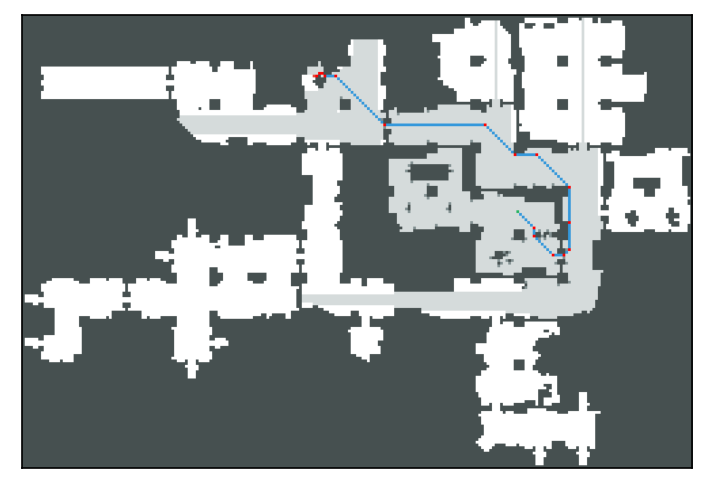

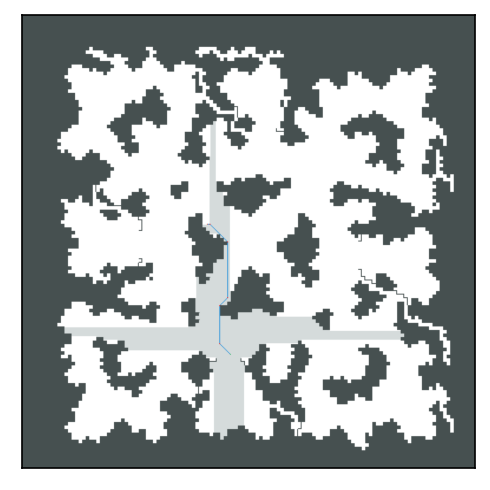

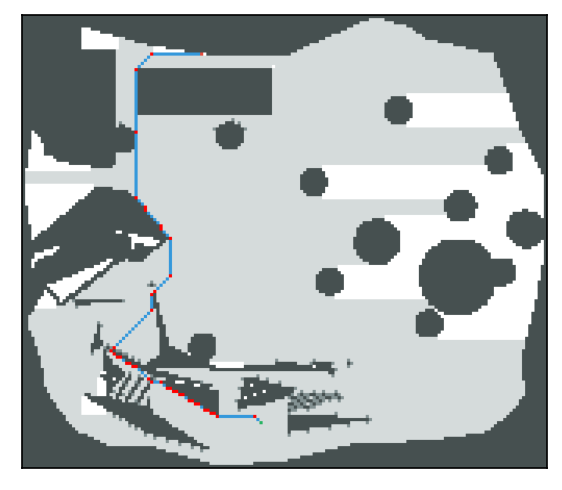

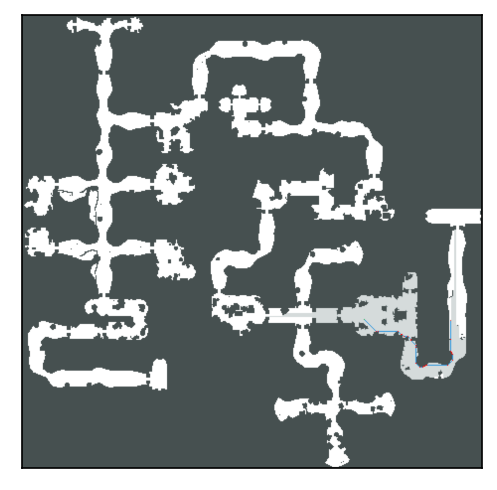

In [24]:
%time jps_data = jps_test()

In [25]:
assert(len(jps_data["len"]) == len(astar_data["len"]))

eps = 0.05
for i in range(len(jps_data["len"])):
    if(("True" if jps_data["len"][i] + eps > astar_data["len"][i] and jps_data["len"][i] - eps < astar_data["len"][i] else "False") == "False"):
        print(i, jps_data["len"][i], astar_data["len"][i])

59 46.52691193458119 44.76955262170046
89 74.18376618407356 67.69848480983498
100 80.87005768508881 79.698484809835
125 103.76955262170048 102.59797974644661
129 101.49747468305831 97.98275605729684
130 104.35533905932736 103.52691193458115
149 118.52691193458118 116.18376618407353
150 119.7401153701776 118.91168824543134
161 131.42640687119285 130.5979797464466
167 133.74011537017762 130.91168824543138
177 141.25483399593904 138.42640687119288
187 154.18376618407353 147.15432893255064
195 157.9116882454314 156.7401153701776
218 163.02438661763952 162.43860018001277
222 169.18376618407353 166.25483399593907
228 167.5685424949238 166.39696961967016
455 161.40916292848974 160.23759005323583
561 48.38477631085024 47.798989873223334
598 81.94112549695429 77.8406204335659
617 94.698484809835 93.04163056034258
618 100.49747468305831 95.52691193458112
633 107.94112549695429 105.45584412271566
639 110.15432893255071 109.56854249492373
654 126.92388155425117 119.40916292848962
657 123.284271247

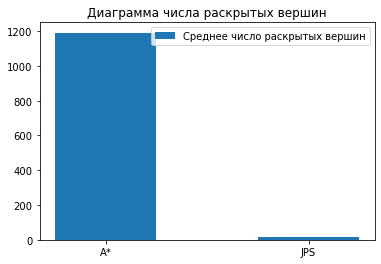

In [26]:
data = [np.mean(astar_data["st"]), 
        np.mean(jps_data["ex"])]
names = ['A*', 'JPS']

width = 1

fig, ax = plt.subplots()

ax.bar(np.arange(2), data, width / 2, label='Среднее число раскрытых вершин')

ax.set_title('Диаграмма числа раскрытых вершин')
ax.set_xticks(np.arange(2))
ax.set_xticklabels(names)
ax.legend()

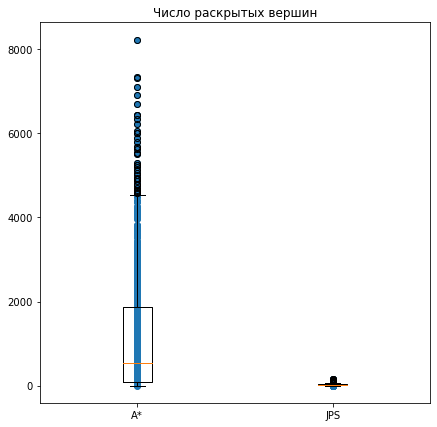

In [27]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    x=[1] * 1000 + [2] * 1000,
    y=astar_data["st"] + jps_data["ex"],
)
ax.boxplot([
    astar_data["st"],
    jps_data["ex"],
],
    labels=['A*', 'JPS']
)
ax.set_title('Число раскрытых вершин')
plt.show()

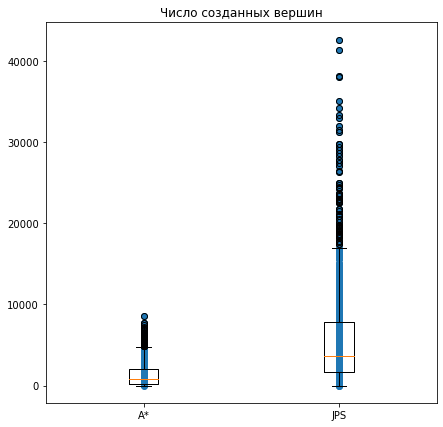

In [28]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    x=[1] * 1000 + [2] * 1000,
    y=astar_data["nc"] + jps_data["vis"],
)
ax.boxplot([
    astar_data["nc"],
    jps_data["vis"],
],
    labels=['A*', 'JPS']
)
ax.set_title('Число созданных вершин')
plt.show()

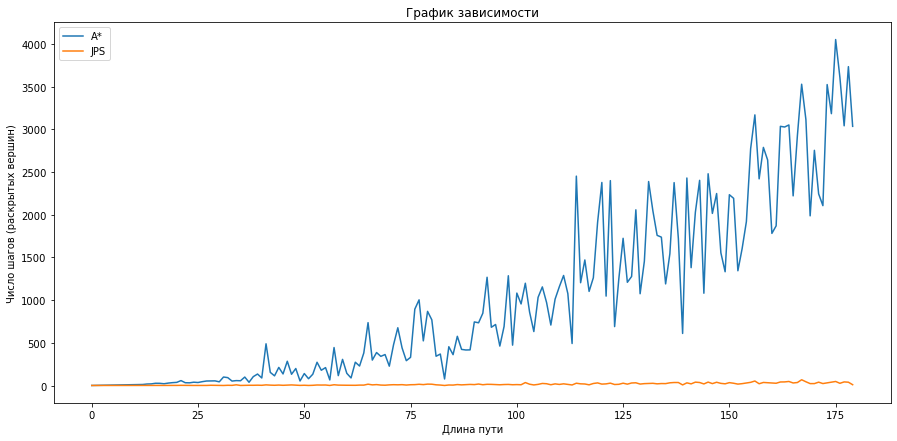

In [33]:
max_len = 0
for i in range(len(astar_data["len"])):
    if astar_data["len"][i] > max_len:
        max_len = astar_data["len"][i]
max_len = int(max_len)

ast_dep = [[0 for i in range(max_len + 1)] for j in range(2)]
jps_dep = [[0 for i in range(max_len + 1)] for j in range(2)]
for i in range(len(astar_data["len"])):
    ast_dep[0][int(astar_data["len"][i])] += astar_data["st"][i]
    ast_dep[1][int(astar_data["len"][i])] += 1
    jps_dep[0][int(astar_data["len"][i])] += jps_data["ex"][i]
    jps_dep[1][int(astar_data["len"][i])] += 1
    
for i in range(max_len + 1):
    if ast_dep[1][i] != 0:
        ast_dep[0][i] = ast_dep[0][i] / ast_dep[1][i]
    if jps_dep[1][i] != 0:
        jps_dep[0][i] = jps_dep[0][i] / jps_dep[1][i]
plt.figure(figsize=(15, 7))
x = [i for i in range(max_len + 1)]

plt.plot(x, ast_dep[0])
plt.plot(x, jps_dep[0])


plt.title("График зависимости")
plt.xlabel("Длина пути")
plt.ylabel("Число шагов (раскрытых вершин)")
plt.legend(['A*', 'JPS'])
plt.show()

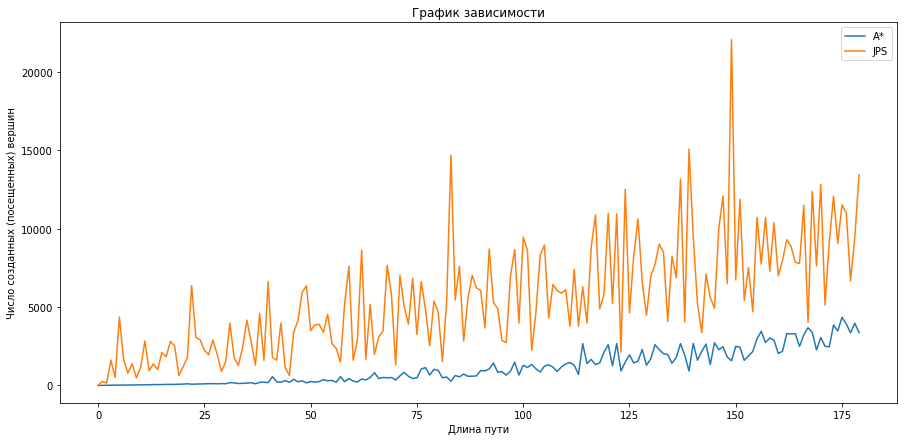

In [35]:
ast_dep = [[0 for i in range(max_len + 1)] for j in range(2)]
jps_dep = [[0 for i in range(max_len + 1)] for j in range(2)]
for i in range(len(astar_data["len"])):
    ast_dep[0][int(astar_data["len"][i])] += astar_data["nc"][i]
    ast_dep[1][int(astar_data["len"][i])] += 1
    jps_dep[0][int(astar_data["len"][i])] += jps_data["vis"][i]
    jps_dep[1][int(astar_data["len"][i])] += 1
    
for i in range(max_len + 1):
    if ast_dep[1][i] != 0:
        ast_dep[0][i] = ast_dep[0][i] / ast_dep[1][i]
    if jps_dep[1][i] != 0:
        jps_dep[0][i] = jps_dep[0][i] / jps_dep[1][i]
        
plt.figure(figsize=(15, 7))
x = [i for i in range(max_len + 1)]

plt.plot(x, ast_dep[0])
plt.plot(x, jps_dep[0])

plt.title("График зависимости")
plt.xlabel("Длина пути")
plt.ylabel("Число созданных (посещенных) вершин")
plt.legend(['A*', 'JPS'])
plt.show()

[Text(0, 0, '1 A*'),
 Text(1, 0, '1 JPS'),
 Text(2, 0, '2 A*'),
 Text(3, 0, '2 JPS'),
 Text(4, 0, '3 A*'),
 Text(5, 0, '3 JPS'),
 Text(6, 0, '4 A*'),
 Text(7, 0, '4 JPS')]

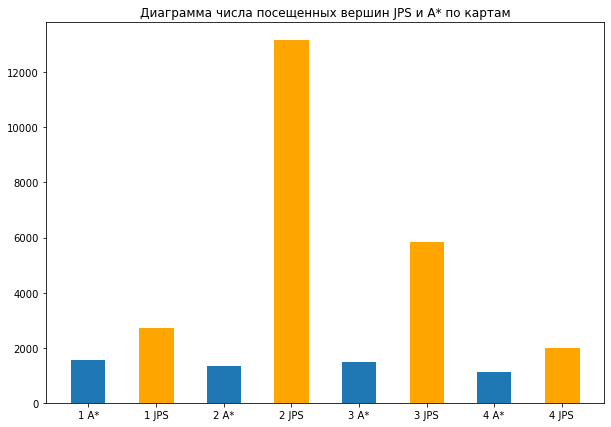

In [50]:
data = [np.mean(astar_data["nc"][:250]),
        np.mean(jps_data["vis"][:250]),
        np.mean(astar_data["nc"][250:500]),
        np.mean(jps_data["vis"][250:500]),
        np.mean(astar_data["nc"][500:750]),
        np.mean(jps_data["vis"][500:750]),
        np.mean(astar_data["nc"][750:1000]),
        np.mean(jps_data["vis"][750:1000])]
names = ['1 A*', '1 JPS', '2 A*', '2 JPS', '3 A*', '3 JPS', '4 A*', '4 JPS']

width = 1

fig, ax = plt.subplots(figsize=(10, 7))

bars = ax.bar(np.arange(8), data, width / 2, label='Среднее число раскрытых вершин')
for i, bar in enumerate(bars):
    if i % 2 == 1:
        bar.set_color("orange")

ax.set_title('Диаграмма числа посещенных вершин JPS и A* по картам')
ax.set_xticks(np.arange(8))
ax.set_xticklabels(names)